In [21]:
import os, sys
parent_dir = os.path.abspath('..')

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [23]:
import datetime as dt
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from methods import get_autoregrmatrix

%matplotlib inline

In [24]:
PATH = "https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv"
data = pd.read_csv(PATH)

In [54]:
data_aqi_index = data[["aqi", "Date"]]
data_aqi_index = data_aqi_index.set_index("Date").sort_index()

x_train = data_aqi_index["aqi"]["2013-01-01":"2018-01-01"]
x_test = data_aqi_index["aqi"]["2018-01-02":"2020-12-31"]

In [26]:
data_aqi_index.head()

,aqi
Date,
2013-01-01,125
2013-01-02,79
2013-01-03,67
2013-01-04,62
2013-01-05,57


In [27]:
def linear_regression_predict(x_train, x_test, delay, regressors=10):
    # Функция формирует матрицу Генкеля и на её основе делает предсказание
    X_train, y_train = get_autoregrmatrix(x_train, delay, regressors)
    X_test, y_test = get_autoregrmatrix(x_test, delay, regressors)

    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    linear_regression_predict = linear_regression.predict(X_test)

    return y_test[:delay], linear_regression_predict[:delay]

In [28]:
def get_optimal_numb_of_regressors(x_train, x_test, delay=1):
    # Функция для определения оптимального кол-ва регрессоров для функции linear_regression_predict
    mae_results = []
    numbs_of_regressors = []

    for n_regressors in range(1, 100):
        y_test, y_predict = linear_regression_predict(
            x_train, x_test, delay, n_regressors
        )
        mae_results.append(mean_absolute_error(y_test, y_predict))
        numbs_of_regressors.append(n_regressors)

    min_mae = min(mae_results)
    optimal_numb_of_regressors = mae_results.index(min_mae) + 1
    return numbs_of_regressors, mae_results, min_mae, optimal_numb_of_regressors

In [29]:
numbs_of_regressors, mae_results, min_mae, optimal_numb_of_regressors = get_optimal_numb_of_regressors(x_train, x_test, 1)

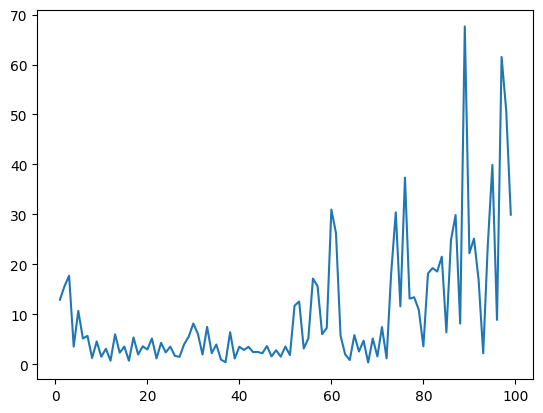

In [30]:
plt.plot(numbs_of_regressors, mae_results)

Выбираем K=30 т.к дальше качество перестаёт существенно расти.

In [31]:
def lin_reg_with_shift(x_train, x_test, steps, regressors=30):
    # Модификация linear_regression_predict со сдвигом на 1 день
    delay = 1  # горизонn прогнозирования
    X_train, y_train = get_autoregrmatrix(x_train, delay, regressors)

    linear_regression = LinearRegression()
    linear_regression = linear_regression.fit(X_train, y_train)

    for _ in range(steps):
        X_train, y_train = get_autoregrmatrix(x_train, delay, regressors)
        linear_regression_predict = linear_regression.predict(X_train)

        # перезаписываем x_train
        x_train = x_train[1:]
        next_dt = dt.datetime.strptime(x_train.index[-1], "%Y-%m-%d").date() + dt.timedelta(days=1)
        x_train.loc[next_dt.isoformat()] = linear_regression_predict[0]

    return x_train[-steps:], x_test[:steps]

In [32]:
lin_reg_with_shift_pred, y_test = lin_reg_with_shift(x_train, x_test, 60, 30)

In [33]:
mean_absolute_error(y_test[:10], lin_reg_with_shift_pred[:10]), mean_squared_error(y_test[:10], lin_reg_with_shift_pred[:10])

(29.83034199786037, 966.5352414877516)

In [34]:
mean_absolute_error(y_test[:30], lin_reg_with_shift_pred[:30]), mean_squared_error(y_test[:30], lin_reg_with_shift_pred[:30])

(26.01249928910767, 759.8274609396535)

In [35]:
mean_absolute_error(y_test[:60], lin_reg_with_shift_pred[:60]), mean_squared_error(y_test[:60], lin_reg_with_shift_pred[:60])

(37.4689136583775, 1826.1565130872966)

In [36]:
data_aqi_subindex = data.set_index("Date").sort_index()
data_aqi_subindex = data_aqi_subindex[
    [
        "aqi",
        "CO_Concentration",
        "NO2_Concentration",
        "O3_Concentration",
        "PM10_Concentration",
        "PM2.5_Concentration",
        "SO2_Concentration",
    ]
]
data_aqi_subindex = data_aqi_subindex.dropna()

In [37]:
data_aqi_subindex.head()

,aqi,CO_Concentration,NO2_Concentration,O3_Concentration,PM10_Concentration,PM2.5_Concentration,SO2_Concentration
Date,,,,,,,
2013-01-01,125,0.511042,30.759775,49.709444,204.521183,42.600000,13.191861
2013-01-02,79,0.513333,26.054568,52.687887,15.570061,25.800000,1.925773
2013-01-03,67,0.473333,31.372220,40.397083,13.538415,20.046667,2.064878
2013-01-04,62,0.479583,27.555411,55.400000,15.922422,17.530000,3.294757
2013-01-05,57,0.320208,25.538422,54.221250,10.792538,15.092000,1.299010


In [38]:
x_train = data_aqi_subindex["2013-01-01":"2018-01-01"]
x_test = data_aqi_subindex["2018-01-02":"2020-12-31"]
y_train = x_train[["aqi"]]
y_test = x_test[["aqi"]]

del x_train["aqi"]
del x_test["aqi"]

In [39]:
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(x_train, y_train)

In [40]:
lin_reg_predict = lin_reg.predict(x_train[-60:])

In [41]:
mean_absolute_error(y_test[:10], lin_reg_predict[:10]), mean_squared_error(y_test[:10], lin_reg_predict[:10])

(14.35520327782757, 370.106891062824)

In [42]:
mean_absolute_error(y_test[:30], lin_reg_predict[:30]), mean_squared_error(y_test[:30], lin_reg_predict[:30])

(19.616859322726032, 551.6050835559946)

In [43]:
mean_absolute_error(y_test[:60], lin_reg_predict[:60]), mean_squared_error(y_test[:60], lin_reg_predict[:60])

(20.12127049338774, 608.3665455228024)

In [30]:
modelsvr = SVR(gamma=0.1, kernel="linear", C=1000)
modelsvr = modelsvr.fit(x_train, y_train["aqi"])

In [44]:
# Можно загрузить уже обученную модель
modelsvr = pickle.load(open("../models/SVR.pkl", "rb"))

In [45]:
svr_predict = modelsvr.predict(x_train[-60:])

In [46]:
mean_absolute_error(y_test[:10], svr_predict[:10]), mean_squared_error(y_test[:10], svr_predict[:10])

(14.168529192871393, 374.9321711998606)

In [47]:
mean_absolute_error(y_test[:30], svr_predict[:30]), mean_squared_error(y_test[:30], svr_predict[:30])

(21.86029363409434, 678.719715241936)

In [48]:
mean_absolute_error(y_test[:60], svr_predict[:60]), mean_squared_error(y_test[:60], svr_predict[:60])

(22.384242598004068, 754.1745838750716)

In [37]:
std_slc = StandardScaler()
logistic_reg = LogisticRegression()
pipe = Pipeline(steps=[("std_slc", std_slc), ("logistic_reg", logistic_reg)])

C = np.logspace(-4, 4, 50)
penalty = ["l1", "l2"]

parameters = dict(logistic_reg__C=C, logistic_reg__penalty=penalty)

In [ ]:
log_reg = GridSearchCV(pipe, parameters)
log_reg = log_reg.fit(x_train, y_train["aqi"])

In [39]:
log_reg.best_params_

{'logistic_reg__C': 6866.488450042998, 'logistic_reg__penalty': 'l2'}

In [49]:
# Можно загрузить уже обученную модель
log_reg = pickle.load(open("../models/LOGREG.pkl", "rb"))

In [50]:
log_reg_predict = log_reg.predict(x_train[-60:])

In [51]:
mean_absolute_error(y_test[:10], log_reg_predict[:10]), mean_squared_error(y_test[:10], log_reg_predict[:10])

(10.3, 149.3)

In [52]:
mean_absolute_error(y_test[:30], log_reg_predict[:30]), mean_squared_error(y_test[:30], log_reg_predict[:30])

(6.833333333333333, 77.63333333333334)

In [53]:
mean_absolute_error(y_test[:60], log_reg_predict[:60]), mean_squared_error(y_test[:60], log_reg_predict[:60])

(13.616666666666667, 330.31666666666666)

In [4]:
# Baseline mean value for n steps behind
def mean_value_predict(data, x_test, steps):
    mean_value = int(data.tail(steps).mean())
    return x_test[:steps], np.stack([mean_value for _ in range(steps)])

In [56]:
y_test, mean_value_predict = mean_value_predict(x_train, x_test, 60)

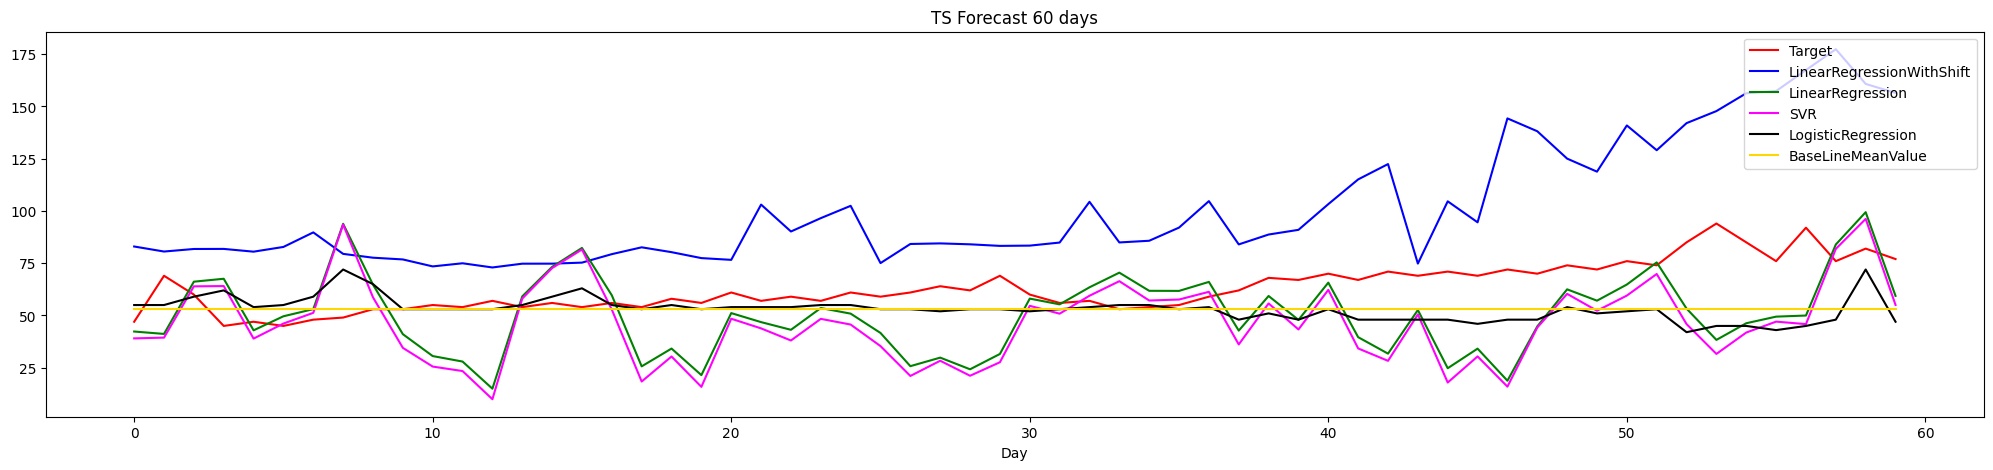

In [60]:
steps = 60
x_steps = np.arange(steps)

plt.figure(figsize=(25, 5))
plt.title(f"TS Forecast {steps} days")

plt.xlabel("Day")
plt.plot(x_steps, y_test[:steps], color="red", label="Target")
plt.plot(x_steps, lin_reg_with_shift_pred, color="blue", label="LinearRegressionWithShift")
plt.plot(x_steps, lin_reg_predict[:steps], color="green", label="LinearRegression")
plt.plot(x_steps, svr_predict[:steps], color="magenta", label="SVR")
plt.plot(x_steps, log_reg_predict[:steps], color="black", label="LogisticRegression")
plt.plot(x_steps, mean_value_predict, color="gold", label="BaseLineMeanValue")
plt.legend(loc="upper right")

Из всех линейных моделей близко к baseline подошла только логистическая регрессия. На отрезках до 10 дней она показывает результат лучше, но при длительном прогнозе проигрывает.